<a href="https://colab.research.google.com/github/rishabh-katoch/ExData_Plotting1/blob/master/SentimentBasedProductRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

The landscape of modern commerce has evolved significantly, with e-commerce emerging as a dominant force. Gone are the days of traditional brick-and-mortar sales; instead, companies establish online platforms to connect directly with consumers. Giants like Amazon, Flipkart, and others have paved the way, offering a vast array of products accessible with a few clicks.

Enterprises like 'Ebuss' are seizing opportunities in this thriving market, carving out niches across diverse product categories. From household essentials to electronics, Ebuss caters to varied consumer needs, aiming to secure a substantial market share.

Yet, in this dynamic arena, staying competitive demands innovation. Ebuss recognizes the importance of leveraging technology to enhance user experience and solidify its position. To compete with established leaders like Amazon and Flipkart, it's crucial to not just keep pace but to lead the way.

As a seasoned Machine Learning Engineer at Ebuss, the task at hand is clear: develop a model to refine product recommendations based on user feedback. This entails crafting a sentiment-based recommendation system, encompassing several key steps:

**1. Data Acquisition and Sentiment Analysis:** Gather user reviews and ratings to discern sentiment.

**2. Building a Recommendation Engine:** Construct a robust recommendation system leveraging the insights from sentiment analysis.

**3. Enhancing Recommendations with Sentiment Analysis:** Integrate sentiment analysis results to fine-tune and personalize product recommendations.

**4. End-to-End Deployment:** Bring the project to fruition by deploying a seamless user interface, facilitating intuitive interaction for users.

In this fast-paced e-commerce landscape, staying ahead demands not just meeting but exceeding customer expectations. With a sentiment-driven approach to recommendations, Ebuss aims to elevate the shopping experience, fostering customer satisfaction and loyalty.

In [6]:
#general purpose libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)

In [7]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
#Modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

### Loading the Dataset

In [9]:
# importing dataset
df_reviews = pd.read_csv("sample30.csv")
df_reviews.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive


### Exploratory Data Analysis - Data Cleaning and Preprocessing

In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [11]:
def calcMissingRowCount(df):
    # summing up the missing values (column-wise) and displaying fraction of NaNs
    return df.isnull().sum()

calcMissingRowCount(df_reviews)

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [12]:
# Remove the missing row of user_sentiment
df_reviews = df_reviews[~df_reviews.user_sentiment.isnull()]

In [13]:
#map the categorical user_sentiment to numerical 1 or 0 for modelling
df_reviews['user_sentiment'] = df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

In [14]:
#get the value count of user_sentiments column
df_reviews["user_sentiment"].value_counts(normalize=True)

user_sentiment
1    0.89
0    0.11
Name: proportion, dtype: float64

<Axes: xlabel='user_sentiment', ylabel='count'>

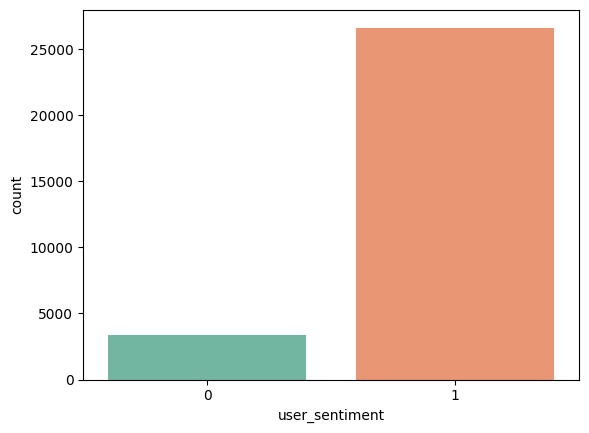

In [15]:
#Visualize using count plot
sns.countplot(x='user_sentiment', data= df_reviews, palette="Set2")

We can see overrepresentation of positive reviews. we may have to do Class Imbalance techniques during modelling.

In [16]:
df_reviews["reviews_rating"].describe()

count    29999.00
mean         4.48
std          0.99
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: reviews_rating, dtype: float64

In [17]:
df_reviews["reviews_rating"].value_counts()

reviews_rating
5    20830
4     6020
1     1384
3     1345
2      420
Name: count, dtype: int64

<Axes: xlabel='reviews_rating', ylabel='count'>

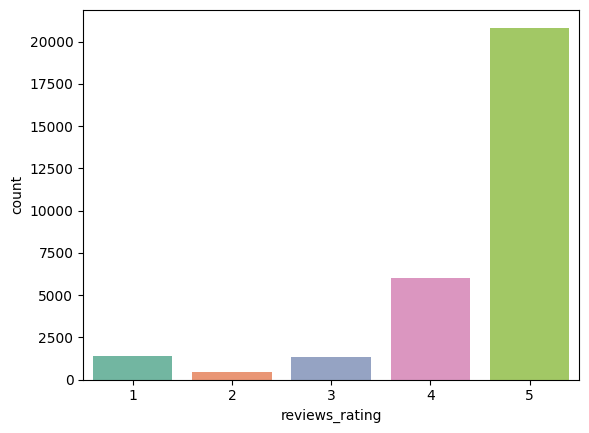

In [18]:
#visualize the user_rating..
sns.countplot(x='reviews_rating', data= df_reviews, palette="Set2")

In [19]:
df_reviews[df_reviews["user_sentiment"]==1]["reviews_rating"].describe()

count    26632.00
mean         4.56
std          0.87
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: reviews_rating, dtype: float64

In [20]:
df_reviews[df_reviews["user_sentiment"]==0]["reviews_rating"].describe()

count    3367.00
mean        3.87
std         1.54
min         1.00
25%         3.00
50%         5.00
75%         5.00
max         5.00
Name: reviews_rating, dtype: float64

In [21]:
df_reviews[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
9,Don't buy,Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund,1
11,Waste of Money,Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.,1
14,Disappointed,First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.,1
18,Pretty nice,"I bought this because it had better reviews than the his and hers jelly, but I feel like it didn't work that well for us. It was kind of warm-feeling, but that's about it. I guess I don't know what's supposed to happen! Lol",3
54,New formula is terrible,"I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.",1
...,...,...,...
29050,Didn't Do Much For Dryness,"I received this product from Influenster. I absolutely love the whole system together, it made my hair oil-free for 48 hours. But I expected the conditioner to do more for the dryness at the ends of my hair like advertised. I didn't really notice much of a different in dryness before and after I...",3
29051,Not the best,"I used this product for a month straight before reviewing it and I'm not really all that impressed. My hair still gets pretty oily, my ends are still dry.... I mean it cleaned my hair I guess. It's nothing spectacular really. It didn't make my hair extremely soft but it didn't make my hair feel ...",3
29053,clay conditioning,Got this item as a compliment from influenster but it really made my hair smooth and shining after the usage. This review was collected as part of a promotion.,3
29054,Eh,"I am not in love with the conditioner. The clay mask and shampoo are GREAT but I didn't feel like this did anything for my ends. I would buy the other two, but not this, probably because I have fine hair and my ends need deep conditioning. Smells great though! I got this product free for testing...",3


In [22]:
df_reviews[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
92,hydrating but not too heavy,It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.,4
96,This product has made a real difference on my skin,In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.,4
100,Noticed a difference in just two weeks!,This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.,4
106,Very rich cream,"I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.",4
117,Not greasy,"I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.",4
...,...,...,...
29818,Great Product,"I received a complimentary sample of this product and it worked so well for my hair! I have very thick hair so my roots always get oily and my ends are dry, this left my hair the cleanest it's felt in a long time. Will def recommend this to my family and friends! This review was collected as par...",5
29855,Great,This has prolonged the color in my hair! Not only is my hair healthier but I think I'll have to visit my stylist less! This review was collected as part of a promotion.,5
29858,Makes my hair soft and shiny without excess oil!,"This conditioner makes my hair very soft without weighing it down! I was afraid it'd make my roots more oily and weight them down, but it doesn't one bit! My hair is colored, and it hasn't faded out the color either! I'd highly recommend giving this a try! This review was collected as part of a ...",5
29862,Great Conditioner,This conditioner has become a staple in my hair regimen This review was collected as part of a promotion.,5


In [23]:
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,597,140,220,550,1860,3367
1,787,280,1125,5470,18970,26632
All,1384,420,1345,6020,20830,29999


As per the above results, there looks to be mismtach between review_rating and user_sentiment. there are records that have higher user rating but user sentiment is negative and lower user rating but user sentiment is positive. We can either clean up those records or update the target column to the correct user sentiment, so that will be helpful for modelling. Here, updating the user_sentiment to 0 (but was 1) when the reviews_rating is less than 4, and updating the user_sentiment to 1(but was 0), when the reviews_rating is greater than or equal to 4

In [24]:
df_reviews.loc[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4), "user_sentiment"] = 0

In [25]:
df_reviews.loc[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4), "user_sentiment"] = 1

In [26]:
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,1384,420,1345,0,0,3149
1,0,0,0,6020,20830,26850
All,1384,420,1345,6020,20830,29999


from the above table, we can see that we don't have mismatch between the reviews_rating and user_sentiment

In [27]:
df_reviews["user_sentiment"].value_counts()

user_sentiment
1    26850
0     3149
Name: count, dtype: int64

In [28]:
df_reviews["brand"].value_counts()

brand
Clorox                   10585
Warner Home Video         3325
Disney                    1199
L'oreal Paris             1186
FOX                        887
                         ...  
Pacific Natural Foods        1
Noosa                        1
Southern Enterprises         1
SLOAN VALVE COMPANY          1
Universal Music              1
Name: count, Length: 214, dtype: int64

<Axes: xlabel='brand'>

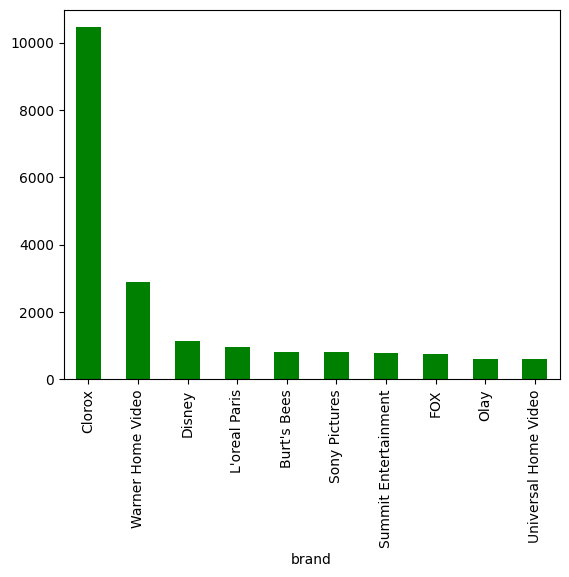

In [29]:
# Filter the top 10 brands among the positive sentiments
df_reviews[df_reviews['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar',color='g')

<Axes: xlabel='brand'>

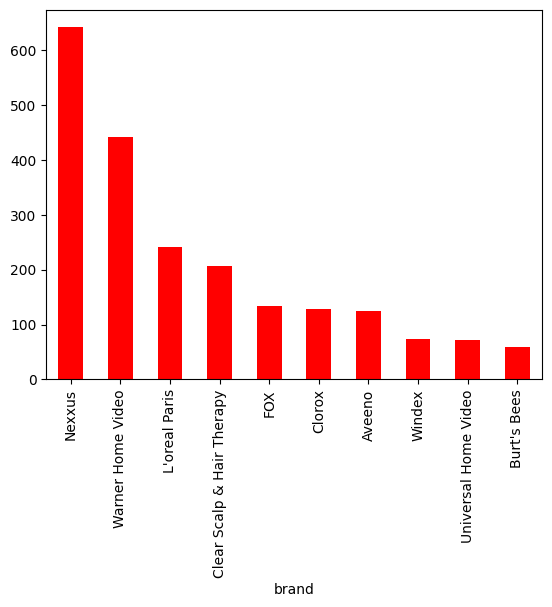

In [30]:
# Filter the top 10 brands among the negative sentiments
df_reviews[df_reviews['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='r')

In [31]:
def filter_products(productId, pos=1):
    review_count = df_reviews[(df_reviews.id==productId) & (df_reviews.user_sentiment==pos)]['brand'].count()
    return review_count

In [32]:
#group the dataframe by product id and view the # of pos review / neg reviews count
df_custom =  df_reviews.groupby('id', as_index=False)['user_sentiment'].count()
df_custom["pos_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 1))
df_custom["neg_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 0))

In [33]:
df_custom.head(10)

,id,user_sentiment,pos_review_count,neg_review_count
0,AV13O1A8GV-KLJ3akUyj,1,1,0
1,AV14LG0R-jtxr-f38QfS,2,2,0
2,AV16khLE-jtxr-f38VFn,27,10,17
3,AV1YGDqsGV-KLJ3adc-O,348,274,74
4,AV1YIch7GV-KLJ3addeG,1,1,0
5,AV1YlENIglJLPUi8IHsX,17,14,3
6,AV1YmBrdGV-KLJ3adewb,18,17,1
7,AV1YmDL9vKc47QAVgr7_,89,74,15
8,AV1Ymf_rglJLPUi8II2v,34,34,0
9,AV1Yn94nvKc47QAVgtst,25,24,1


In [34]:
#sort the product by sentiment % - postive reviews / total number of reviews
df_custom['sentiment %'] = np.round((df_custom['pos_review_count']/df_custom['user_sentiment'])*100,2)
df_custom.sort_values(by='sentiment %', ascending=False)[:20]

,id,user_sentiment,pos_review_count,neg_review_count,sentiment %
0,AV13O1A8GV-KLJ3akUyj,1,1,0,100.0
82,AVpf-lMV1cnluZ0-ub0_,4,4,0,100.0
138,AVpfE5UF1cnluZ0-dY1N,2,2,0,100.0
141,AVpfEqFbilAPnD_xUV28,4,4,0,100.0
143,AVpfErGsLJeJML431yRX,1,1,0,100.0
145,AVpfFGqP1cnluZ0-ddjG,1,1,0,100.0
149,AVpfGRUHilAPnD_xU5nU,5,5,0,100.0
150,AVpfGTRQLJeJML432WYA,8,8,0,100.0
151,AVpfG_ujilAPnD_xVI8L,8,8,0,100.0
153,AVpfH2Rx1cnluZ0-eYtu,3,3,0,100.0


In [35]:
df_reviews["manufacturer"].value_counts()

manufacturer
Clorox                                8546
Test                                  3325
AmazonUs/CLOO7                        2039
L'oreal Paris                         1232
Walt Disney                           1142
                                      ... 
Pacific Foods of Oregon, Inc.            1
Unfi                                     1
Herr's                                   1
Southern Enterprises                     1
Universal Music Group / Cash Money       1
Name: count, Length: 227, dtype: int64

In [36]:
#Let's find out the most common users.
df_reviews["reviews_username"].value_counts()[:10]

reviews_username
mike                 41
byamazon customer    41
chris                32
lisa                 16
sandy                15
tony                 15
rick                 15
dave                 14
john                 14
jojo                 13
Name: count, dtype: int64

<Axes: xlabel='reviews_username'>

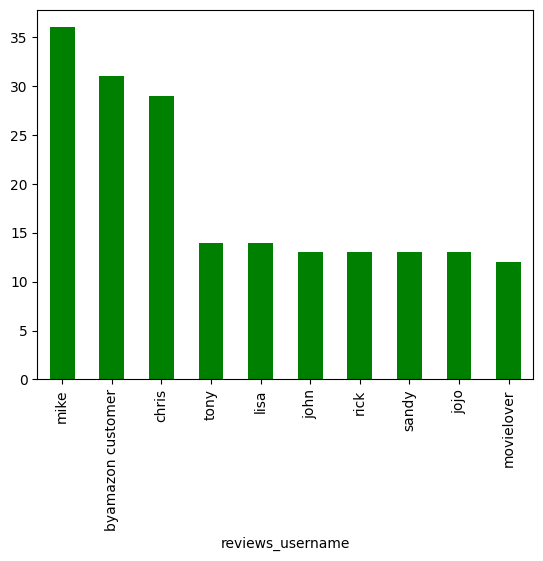

In [37]:
#plot the customers by 'positive user sentiment'
df_reviews[df_reviews['user_sentiment']==1].groupby('reviews_username')['reviews_username'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='g')

<Axes: xlabel='reviews_username'>

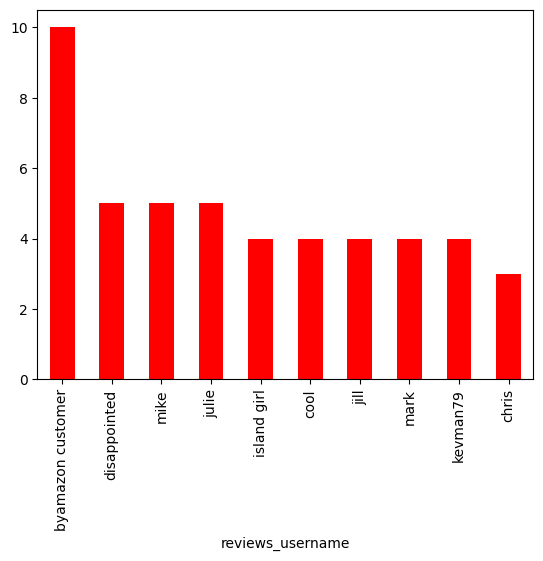

In [38]:
#plot the customers by 'negative user sentiment'
df_reviews[df_reviews['user_sentiment']==0].groupby('reviews_username')['reviews_username'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='r')

In [39]:
#removing nan/null from username
df_reviews = df_reviews[~df_reviews.reviews_username.isnull()]

In [40]:
#Let's combine the reviews_text and reviews_title for better analysis
df_reviews["reviews_title"] = df_reviews["reviews_title"].fillna('')
df_reviews["reviews_full_text"] = df_reviews[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

In [41]:
#get the missing row cout for each of the columns
calcMissingRowCount(df_reviews)

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               40
reviews_didPurchase     14005
reviews_doRecommend      2541
reviews_rating              0
reviews_text                0
reviews_title               0
reviews_userCity        28036
reviews_userProvince    29770
reviews_username            0
user_sentiment              0
reviews_full_text           0
dtype: int64

Required columns for reviews_rating, reviews_text, user_sentiment,reviews_username doesn't have null/na values

### Text Preprocessing for Modelling

In [42]:
import string

In [43]:
df_reviews[["reviews_full_text", "user_sentiment"]].sample(10)

,reviews_full_text,user_sentiment
5395,Good product.. Used to use Freedent until I heard and saw that it contained zinc. Discovered the poligrip I use does not. Like the Ultra Fresh better than the plain.,1
22826,excellent product mon was right!. Great buy,1
17988,"Best Lip Therapy Ever Made. I love this lip therapy, it's the best I've ever had. Constantly working outside and I'm dry areas for work I couldn't ask for anything better. I only wish they made this lip therapy Coca Butter in a tube, because sticking my fingers in to the jar is a turn off and gr...",1
18653,"Great product, great scent. It's the trusted Clorox wipes we've come to count on, with a scent which makes the whole room smell clean.",1
20844,"Good Value. I was skeptical when I took it out of the box. I felt the fire box was a little on the small side, but when damped down it holds a fire quite well. I'm heating 2300 sq. ft. and the far reaches of the home are comfortable. I should note that the house is ""earth insulated"". That is, it...",1
21997,"Just About As Good As It Gets. This film in its acting, direction, photography, and musical score is sheer perfection. The elegant haughtiness and razor-sharp wit of Ralph Richardson as Dr. Sloper enrich a characterization as polished as any of those that great actor ever gave. Olivia de Havilla...",1
8682,Great!. Love this product! Makes cleaning the bathroom so easy!,1
1339,"BB Sunless Tanning Lotion, YES, YES, YES !!!. I have tried dozens of self tanner's, BB self tanner is simply the best, tan's evenly looks natural and is priced very well.",1
25440,"Great price. Great price for this movie, and it was a lot in stock and easy to find!",1
7366,Works well. I like to use them to disinfect surfaces around the house. This review was collected as part of a promotion.,1


In [44]:
'''function to clean the text and remove all the unnecessary elements.'''
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    dictionary = "abc".maketrans('', '', string.punctuation)
    text = text.translate(dictionary)
    text = re.sub("\S*\d\S*", "", text)

    return text

In [45]:
df_clean = df_reviews[['id','name', 'reviews_full_text', 'user_sentiment']]

In [46]:
df_clean["reviews_text"] = df_clean.reviews_full_text.apply(lambda x: clean_text(x))

In [47]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [48]:
stop_words = set(stopwords.words('english'))

def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [49]:
lemmatizer = WordNetLemmatizer()
# Lemmatize the sentence
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(words)

In [50]:
df_clean["reviews_text_cleaned"] = df_clean.reviews_text.apply(lambda x: lemma_text(x))

In [51]:
df_clean.head()

,id,name,reviews_full_text,user_sentiment,reviews_text,reviews_text_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,1,just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it rating all the way her metaphors are just crazy,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected as part of a promotion.,1,good good flavor this review was collected as part of a promotion,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1,good good flavor,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation...",0,disappointed i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what w...,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,0,irritation my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel,irritation husband buy gel u gel caused irritation felt like burn skin wouldnt recommend gel


reviews_text is cleaned to remove stopwords, punctuations,numericals,whitespaces and lemma is derived.

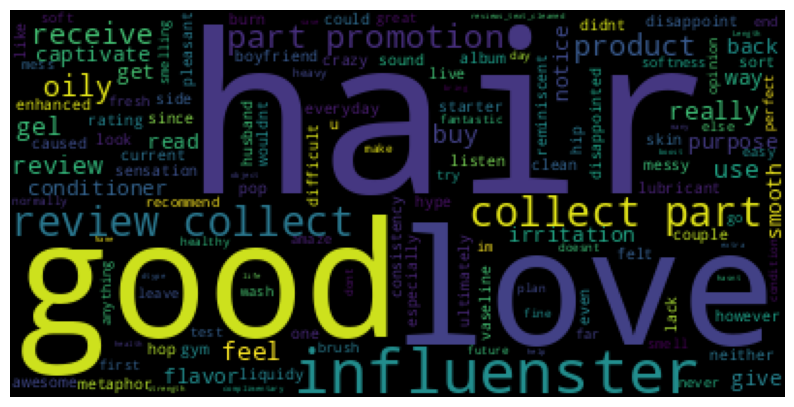

In [52]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stop_words,max_words=200).generate(str(df_clean.reviews_text_cleaned))

print(wordcloud)
plt.figure(figsize= (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

(array([1.0622e+04, 1.2187e+04, 3.9170e+03, 1.5600e+03, 7.5600e+02,
        3.1200e+02, 2.3100e+02, 1.1900e+02, 6.7000e+01, 4.2000e+01,
        3.5000e+01, 3.4000e+01, 1.2000e+01, 3.0000e+00, 1.0000e+01,
        3.0000e+00, 4.0000e+00, 2.0000e+00, 3.0000e+00, 5.0000e+00,
        5.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([3.00000e+00, 7.68400e+01, 1.50680e+02, 2.24520e+02, 2.98360e+02,
        3.72200e+02, 4.46040e+02, 5.19880e+02, 5.93720e+02, 6.67560e+02,
        7.41400e+02, 8.15240e+02, 8.89080e+02, 9.62920e+02, 1.03676e+03,
        1.11060e+03, 1.18444e+03, 1.25828e+03, 1.33212e+03, 1.40596e+03,
        1.47980e+03, 1.553

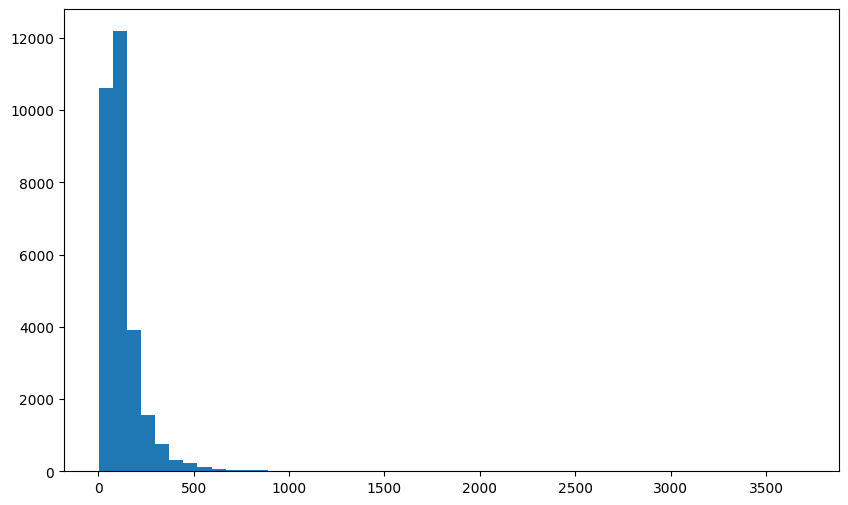

In [53]:
#visualise the data according to the 'Review Text' character length
plt.figure(figsize=(10,6))
reviews_lens = [len(d) for d in df_clean.reviews_text_cleaned]
plt.hist(reviews_lens, bins = 50)

In [54]:
def getMostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [55]:
pos_reviews = df_clean[df_clean['user_sentiment']==1]
getMostCommonWords(pos_reviews['reviews_text_cleaned'],10)

[('great', 14397),
 ('love', 12430),
 ('use', 11725),
 ('product', 10805),
 ('movie', 9855),
 ('review', 8881),
 ('part', 8728),
 ('promotion', 8374),
 ('wipe', 8189),
 ('clean', 8077)]

In [56]:
neg_reviews = df_clean[df_clean['user_sentiment']==0]
getMostCommonWords(neg_reviews['reviews_text_cleaned'],10)

[('product', 1934),
 ('use', 1794),
 ('hair', 1575),
 ('formula', 1439),
 ('new', 1261),
 ('like', 1090),
 ('old', 1078),
 ('good', 1075),
 ('movie', 1033),
 ('gel', 876)]

In [57]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [58]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(pos_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 1]]


,0,1
0,review collect,7920
1,collect promotion,7920
2,clorox wipe,2803
3,great product,1944
4,great movie,1739
5,easy use,1554
6,love clorox,1223
7,love product,1137
8,use clorox,1088
9,good movie,922


In [59]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(neg_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,new formula,520
1,old formula,515
2,bring old,369
3,review collect,346
4,collect promotion,346
5,exxtra gel,205
6,use product,183
7,make hair,157
8,shampoo conditioner,147
9,gel year,127


--1 [[1 1 1 ... 1 1 2]]


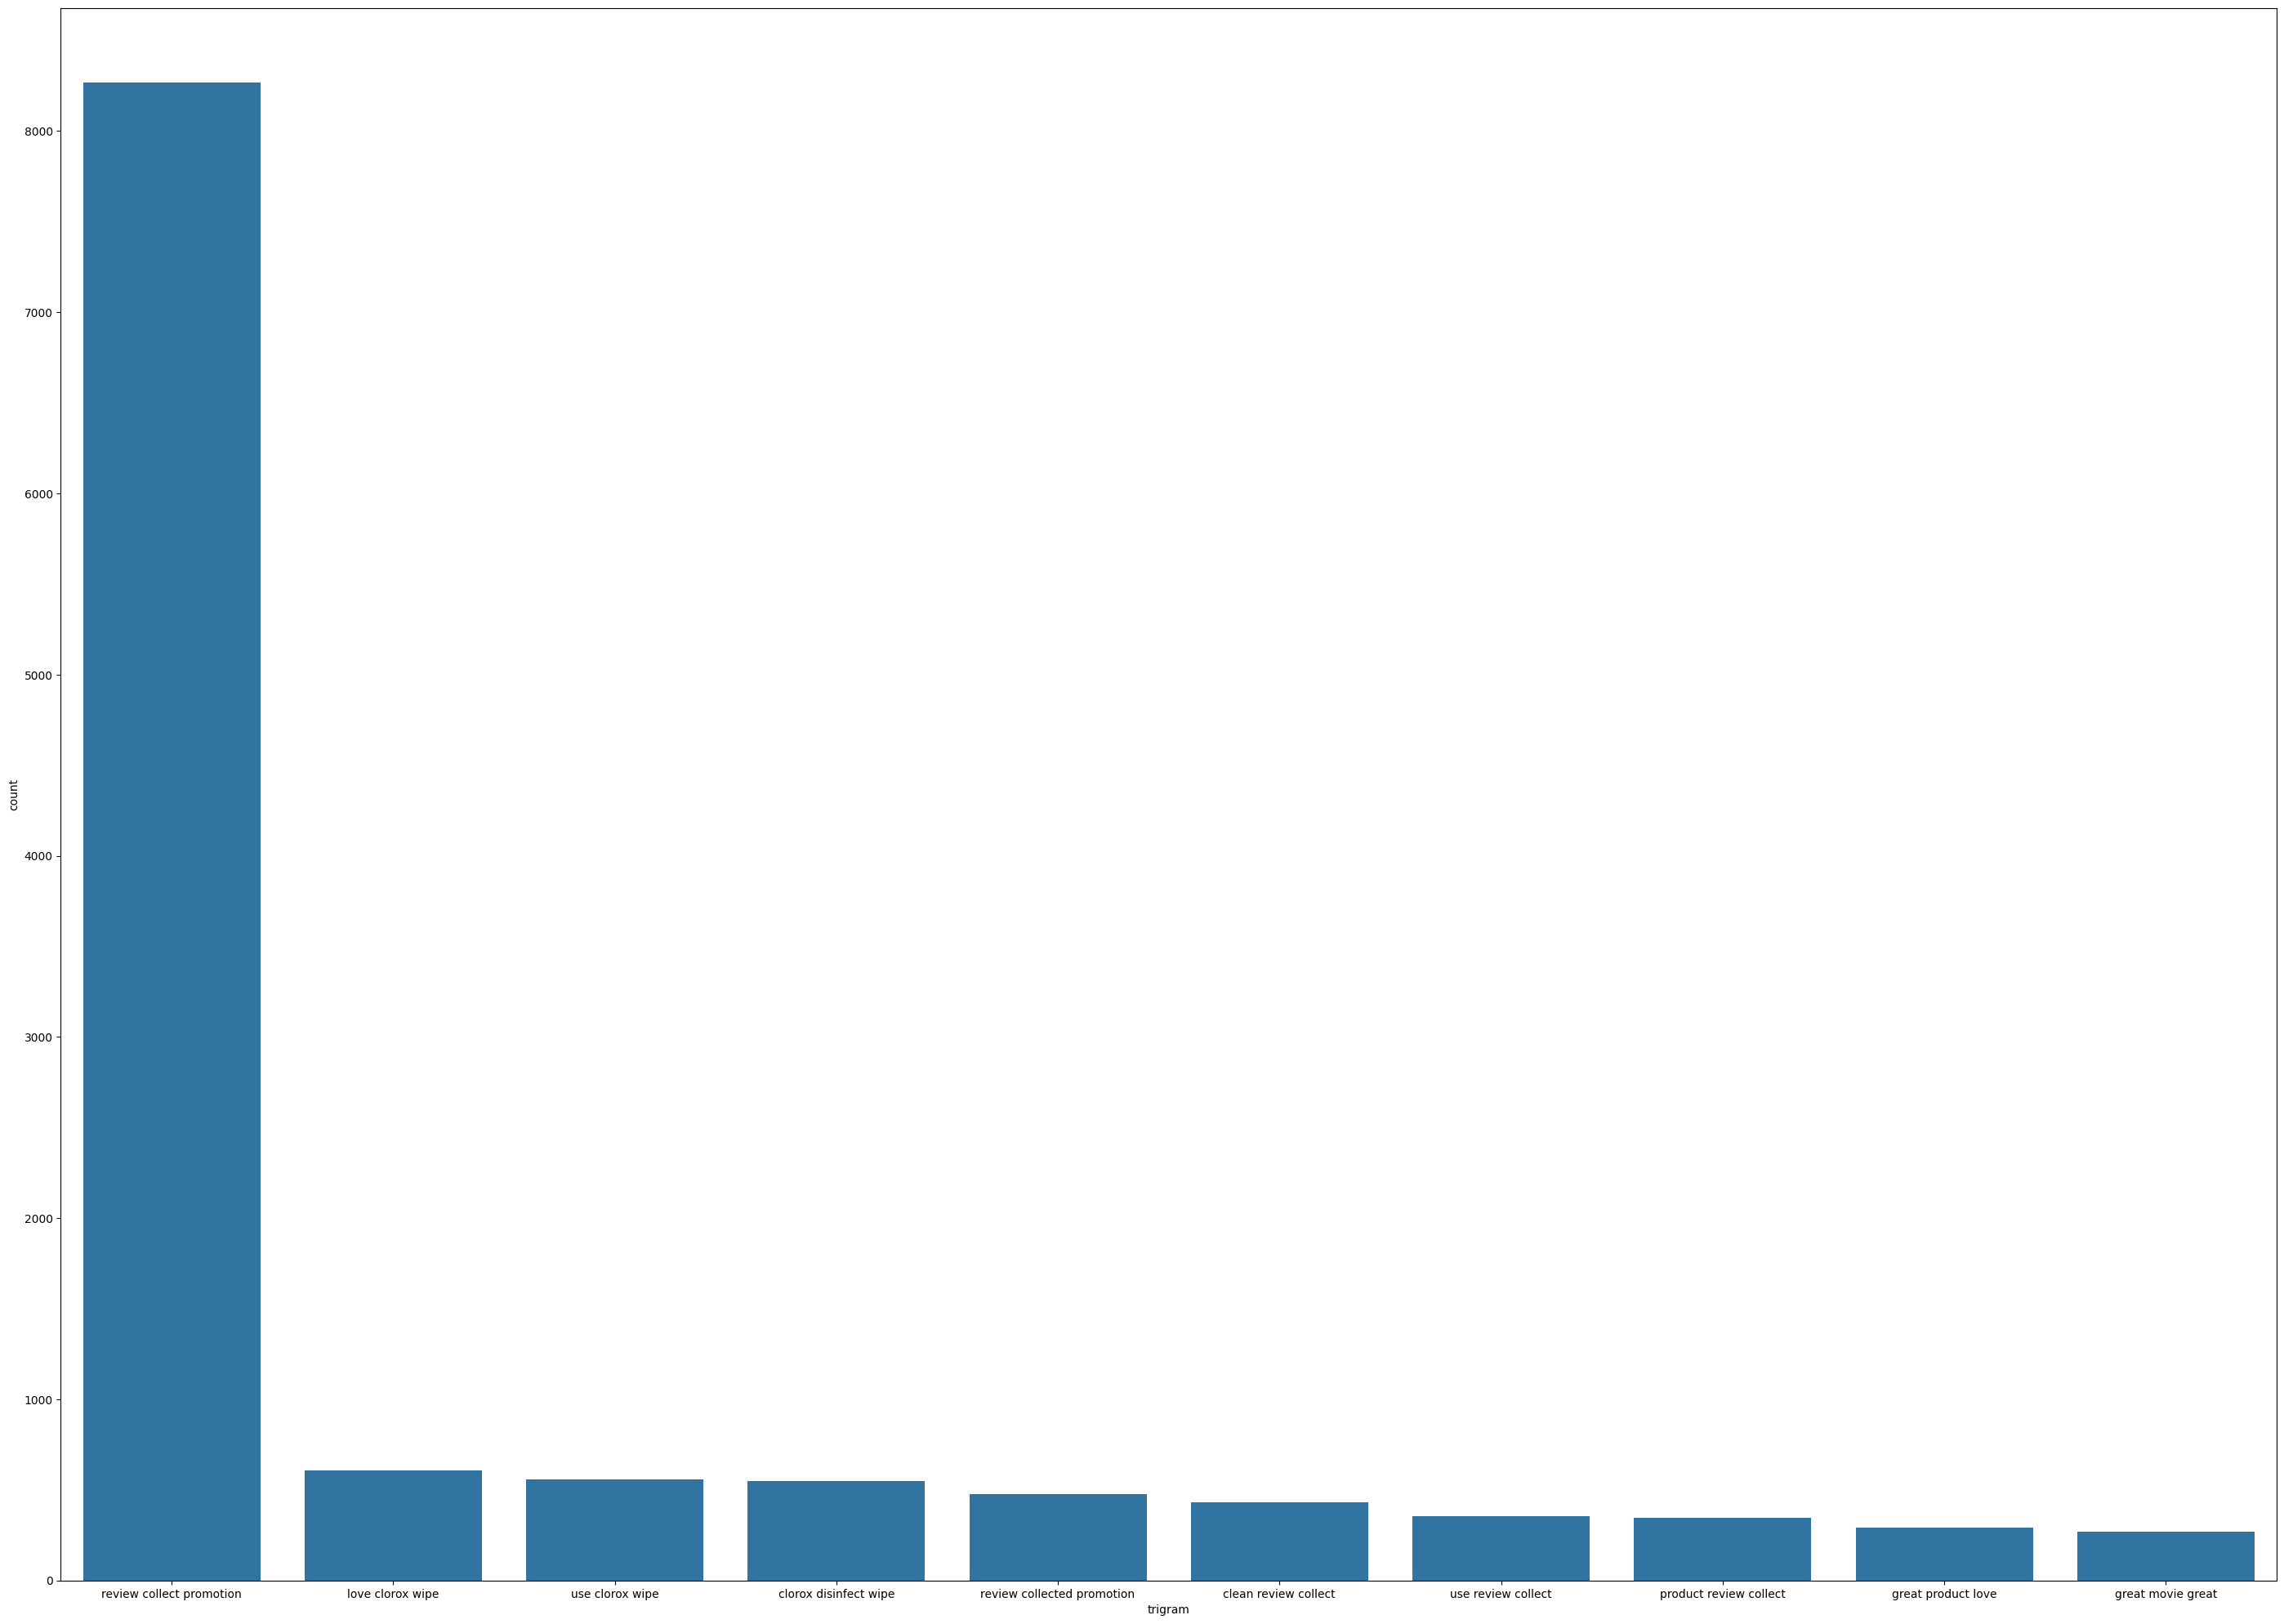

In [60]:
#logic to find the top 10 trigram frequency among the reviews_text in the cleaned datafram(df_clean).
common_words = get_top_n_ngram(df_clean.reviews_text_cleaned, 3, 10)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[35,25])
fig = sns.barplot(x=df3['trigram'], y=df3['count'])

In [61]:
X = df_clean['reviews_text_cleaned']
y = df_clean['user_sentiment']

### Feature Extraction

In [62]:
no_of_classes= len(pd.Series(y).value_counts())

In [63]:
#Distribution of the target variable data in terms of proportions.
for i in range(0,no_of_classes):
    print("Percent of {0}s: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

Percent of 0s:  10.47 %
Percent of 1s:  89.53 %


To Vectorize the data, using TF-IDF vectorizer method to dervie the features from the textual data

As it's clearly a class-imbalance between positive and negative, let's do SMOTE oversampling technique before modelling

In [64]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True,
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_clean['reviews_text_cleaned'])

y= df_clean['user_sentiment']

In [65]:
print(tfidf_vectorizer.get_feature_names_out())

['able' 'absolutely' 'absolutely love' 'act' 'action' 'action movie'
 'actor' 'actually' 'add' 'age' 'ago' 'amaze' 'amazing' 'apply' 'area'
 'ask' 'available' 'away' 'awesome' 'awesome movie' 'awesome product'
 'awful' 'baby' 'bad' 'bag' 'bathroom' 'bathroom kitchen' 'beautiful'
 'bee' 'begin' 'believe' 'best' 'best buy' 'best product' 'big' 'bit'
 'black' 'bleach' 'blu' 'blu ray' 'bluray' 'body' 'bottle' 'box' 'boy'
 'brand' 'break' 'bring' 'bring cocoa' 'bring old' 'brown' 'burt'
 'burt bee' 'buy' 'canister' 'car' 'care' 'carpet' 'carry' 'cast' 'cd'
 'chair' 'change' 'character' 'cheap' 'child' 'chip' 'classic' 'classroom'
 'clay' 'clean' 'clean bathroom' 'clean disinfect' 'clean easy'
 'clean fresh' 'clean great' 'clean kitchen' 'clean love' 'clean mess'
 'clean product' 'clean review' 'clean smell' 'clean ups' 'clean use'
 'clean wipe' 'cleaner' 'cleaning' 'cleanup' 'clear' 'clorox'
 'clorox disinfect' 'clorox love' 'clorox product' 'clorox wipe' 'close'
 'cocoa' 'cold' 'collect' '

In [66]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

### Class imbalance (using SMOTE)

In [67]:
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 20087, 0: 2365})
After Counter({1: 20087, 0: 20087})


### Model Building

In [68]:
from sklearn import metrics
import pickle

In [69]:
class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test


    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)

    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")

        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)

        print("*"*30)
        print("\n")

        metrics.RocCurveDisplay.from_estimator(self.model, self.x_test, self.y_test)

        return self.result_metrics

    def evaluate_metrics(self, y_pred_class):
        result_metrics = []
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)

        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")

        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics

    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])


    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")

        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()

    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))


f1-score/recall score for class 0 is low and this could be due to class-imbalance, though the other metrics seem to be good. Let's use class-imbalance techniques using SMOTE and do the modelling

### Logistic Regression

In [70]:
# Build the Logistic Regression model.
%time

logreg_ci = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelBuilder(logreg_ci, X_train, X_test, y_train, y_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [71]:
# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()



******************************
Accuracy is : 88.1%
Precision is : 96.7%
Recall is : 89.9%
F1 Score is : 93.1%
Roc-Auc Score is:90.1%
******************************


              precision    recall  f1-score   support

           0       0.45      0.73      0.56       770
           1       0.97      0.90      0.93      6714

    accuracy                           0.88      7484
   macro avg       0.71      0.81      0.74      7484
weighted avg       0.91      0.88      0.89      7484

******************************




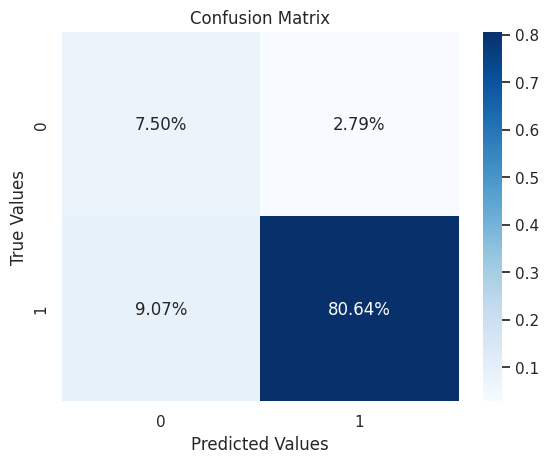

******************************




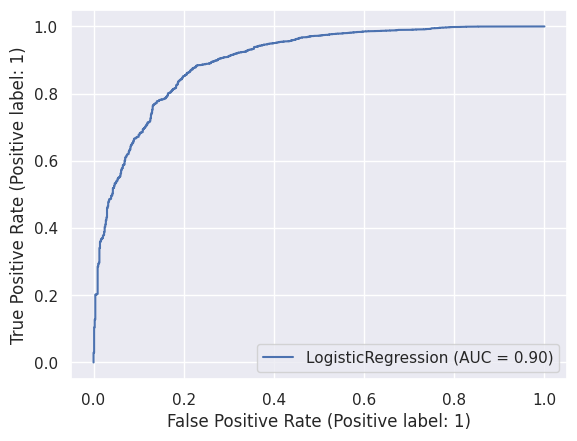

In [72]:
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

F1 Score looks to be good, though the individual class(0) is lesser. let;s try with other alogithms if we can increase the overall F1 and for the individual classes

### Naive Bayes

In [73]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB

In [74]:
mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 81.1%
Precision is : 97.5%
Recall is : 81.0%
F1 Score is : 88.5%
Roc-Auc Score is:89.5%
******************************


              precision    recall  f1-score   support

           0       0.33      0.82      0.47       770
           1       0.98      0.81      0.89      6714

    accuracy                           0.81      7484
   macro avg       0.65      0.82      0.68      7484
weighted avg       0.91      0.81      0.84      7484

******************************




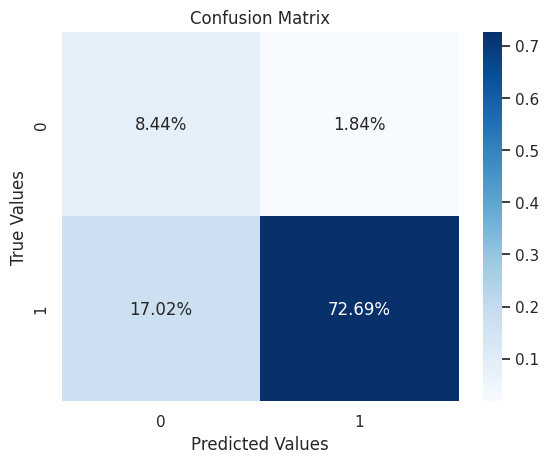

******************************




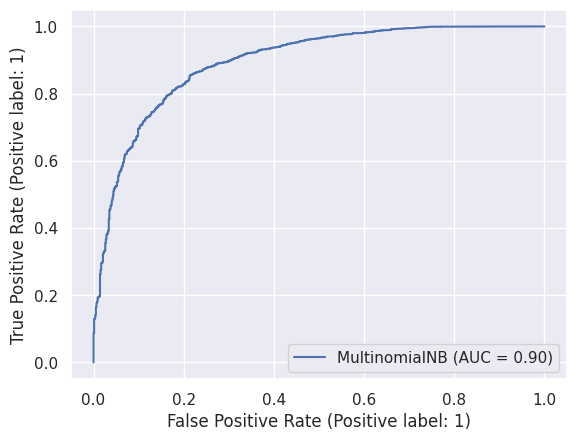

In [75]:
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

### Decision Tree

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [77]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

In [78]:
dt_modelbuilder = ModelBuilder(dt, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 82.4%
Precision is : 95.7%
Recall is : 84.2%
F1 Score is : 89.6%
Roc-Auc Score is:82.4%
******************************


              precision    recall  f1-score   support

           0       0.33      0.67      0.44       770
           1       0.96      0.84      0.90      6714

    accuracy                           0.82      7484
   macro avg       0.64      0.76      0.67      7484
weighted avg       0.89      0.82      0.85      7484

******************************




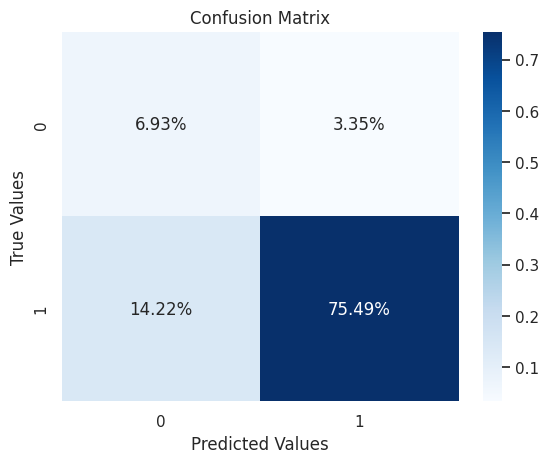

******************************




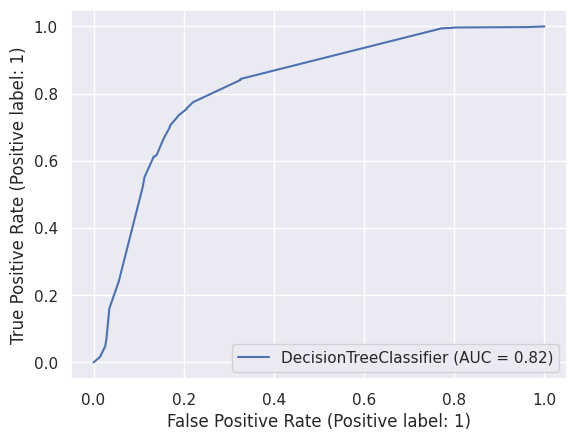

In [79]:
y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)

### Random Forrest

In [80]:
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

In [81]:
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}

In [82]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

In [ ]:
%time
grid_search.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Fitting 4 folds for each of 64 candidates, totalling 256 fits


In [ ]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)

In [ ]:
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

### XGBoost Classifier

In [ ]:
import xgboost as xgb

In [ ]:
xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)

In [ ]:
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

### Model Inference

In [ ]:
xg_metrics

In [ ]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'],
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
        'Decision Tree': dt_metrics_cv,
         'Random Forrest': rf_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest',
                                                    'XG Boost'] )

df_metrics


Comparing the above models on the metrics, XG Boost looks to be a better model, saving the XG Boost model as a pickle file for later use

#### Saving the model

In [ ]:
def save_object(obj, filename):
    filename = "pickle/"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [ ]:
save_object(xgclf, 'sentiment-classification-xg-boost-model')

In [ ]:
save_object(tfidf_vectorizer, 'tfidf-vectorizer')

In [ ]:
save_object(df_clean, 'cleaned-data')

## Recommendation System

Different Approaches to develop Recommendation System -

Here we are going to try with 2 of the Colloboarative filtering techniques:
    - User-User Based Approach
    - Item-Item Based Approach

In [ ]:
df_reviews.info()

In [ ]:
df_recommendation = df_reviews[["id", "name", "reviews_rating", "reviews_username"]]
calcMissingRowCount(df_recommendation)

In [ ]:
#splitting the train and test
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=42)

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(10)

### Creating dummy train and test

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [ ]:
dummy_train.head()

In [ ]:
# The products not rated by user is marked as 1 for prediction.
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)

### User similarity matrix

In [ ]:
df_pivot.index.nunique()

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [ ]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

### Prediction User-User

In [ ]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

In [ ]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

### Find 20 recommendation for the user

In [ ]:
user_input = "08dallas"
print(user_input)

In [ ]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

In [ ]:
#display the top 20 product id, name and similarity_score
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

### Evaluation User-User

In [ ]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

In [ ]:
common.head()

In [ ]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

In [ ]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

In [ ]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [ ]:
user_correlation_df_1.shape

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [ ]:
user_correlation_df_3 = user_correlation_df_2.T

In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

In [ ]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)

In [ ]:
dummy_test.shape

In [ ]:
common_user_based_matrix.head()

In [ ]:
dummy_test.head()

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [ ]:
common_user_predicted_ratings.head()

In [ ]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

### Item Based Recommendation

In [ ]:
df_pivot = pd.pivot_table(train,
    index=product_column,
    columns=user_column,
    values=value_column
)

df_pivot.head()

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head()

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

### Prediction - item-item

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

#### Filtering the rating only for the products not rated by the user for recommendation

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

#### Finding the top 20 recommendation for the user

In [ ]:
# Take the user ID as input
user_input = '08dallas'
print(user_input)

In [ ]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

In [ ]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

#### Evaluation - item-item

In [ ]:
common =  test[test.id.isin(train.id)]
common.shape

In [ ]:
common.head(4)

In [ ]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

In [ ]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

In [ ]:
list_name = common.id.tolist()

In [ ]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [ ]:
df_subtracted

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

In [ ]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [ ]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

On comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2)

In [ ]:
# saving the correlation matrix of user based recommender
save_object(user_final_rating, "user_final_rating")

### Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model

Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model.. the similar method would be used in model.py

In [ ]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_clean[df_clean.id.isin(recommendations)]
        #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
        #transfor the input data using saved tf-idf vectorizer
        X =  tfidf_vectorizer.transform(temp["reviews_text_cleaned"].values.astype(str))
        temp["predicted_sentiment"]= xgclf.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [ ]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("08dallas")

In [ ]:
#get the top 5
get_sentiment_recommendations("08dallas")[:5]

In [ ]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("test123")

In [ ]:
X_sample = tfidf_vectorizer.transform(["Awesome product, will recommend"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

In [ ]:
X_sample = tfidf_vectorizer.transform(["worst product, quality is poor"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample